<h1>
    <center>
    TMA4215 Project 2


### Table of contents
#### 1. Introduction
#### 2. Algorithm 

2.1 Functions used in the algorithms

2.2 The training algorithm 

2.3 The testing algorithm and functions for analysis

#### 3. Deciding parameters

3.1 Batchsize 

3.2 Number of hidden layers, $K$

3.3 Learning parameter, $\tau$

3.4 Dimension of the layers $d$

3.5 Stepsize $h$

3.6 Conclusion


#### 4. Training and testing with suggested functions
4.1 $F(y) = 1-\cos(y)$

4.2 $G(y_1, y_2) = \frac{1}{2}(y_1^2 + y_2^2)$

4.3 Known Hamiltonians
   
    4.3.1 Nonlinar pendulum
    
    4.3.2 Kepler two-body problem

4.3 Unknown Hamiltonian

#### 5. Determine the gradient 

### 1. Introduction

The purpose of this project is to implement a  neural network for estimating a seperable Hamiltonian function $H(p,q) = T(p) + V(p)$ based on data. This is achieved by training the network for $T(p)$ and $V(q)$, computing the gradient of the trained function and use the gradient in the numerical methods symplectic Euler and Størmer-Verlet to approximate the trajectories.

This report first presents the training algorithm and argues for the choices of the parameters $K$, $\tau$, $d$ and $h$ used. Then the model is trained for know functions and Hamiltonians and the results are compared to exact values. This is done to evaluate the accuracy of the network, before it is trained on data given from an unknown Hamiltonian function. Finally, the formulas for computing the gradient are presented and the numerical methods implemented and used, both on known Hamiltonians and the unknown function.

NB: We have chosen to use the inputdata batches from the new trajectories. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from project_2_data_acquisition import generate_data, concatenate
from files import writeParams, readParams, writeScale, readScale, plotObjFnc

The above functions are imported from separate files and are used to generate the input data from the unknown Hamiltonian function, as well as save the values of a trained network to textfiles and reaccess them at a later time. 

### 2. Algorithms

The training algorithm is separated into several smaller codeblocks to simply its structure and make it more readable. It is mainly split into transforming the input data between layers, determining the gradient of the objective function with respect to weights $W$, biases $b$, $\omega$ and $\mu$ and optimising the network with respect to them. Additionally there are various smaller functions for use in the main functions.

#### 2.1 Functions used in the algorithms

In [3]:
def getW(K,d):
    w = np.random.randn(K,d,d)
    return w

def getb(K,d):
    b = np.random.randn(K,d,1)
    return b

def getomega(d):
    omega = np.random.randn(d,1)
    return omega

def getmu():
    mu = np.random.randn(1)
    return mu

The functions above generate random initial values, drawn from a standard normal distribution, for the weights, $W_k$, the biases, $b_k$, $\omega$ and $\mu$. These random values lead to some slight differences when training of the network multiple times for the same dataset. 

In [4]:
def sigma(x):
    return np.tanh(x)

def sigma_div(x):
    return 1 - np.tanh(x)**2

def eta(x):
    return 1/2*(1+np.tanh(x/2))

def eta_div(x):
    return 1/(4*np.cosh(x/2)**2) 

Above, the activating function $\sigma$, which is used in the transformation $\Phi_k: Z_k \rightarrow Z_{k+1}$, and the hypothesis function $\eta$, used in projection from last layer on a scalar $z$, as well as their derivatives, are defined. 

In [5]:
def getZ(Y0, W, b, K, d, I, h, sigma):
    #initialize Z, Z0=Y0
    Z = np.zeros((K+1,d,I))
    Z[0] = Y0

    #finds Zk
    for k in range(1,K+1):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def getP(Z, ypsilon, c, omega, mu, W, b, K, d, I, h, sigma_div, eta_div):
    #initialize P
    P = np.zeros((K+1,d,I))

    #finds P_K
    u = np.transpose(Z[-1])@omega + mu
    P[-1]= omega@np.transpose((ypsilon-c)*eta_div(u))

    #finds P_K-1 to P_0
    for k in range(K-1,0,-1):
        s = W[k]@Z[k] + b[k]
        P[k]=P[k+1] + h*np.transpose(W[k])@(sigma_div(s)*P[k+1])
        
    return P


def getYpsilon(Z, omega, mu, K, eta):
    u = np.transpose(Z[K]) @ omega + mu
    return eta(u)

def getJ(ypsilon, c):
    return 1/2 * np.linalg.norm(ypsilon-c)**2

Here the functions $getZ$, $getP$, $getYpsilon$ and $getJ$ are defined. $getZ$ executes the transfomation $\Phi_k: Z_k \rightarrow Z_{k+1}$ between layers, and $getP$ returns an utility matrix used in calulations of derivatives of the objective function with respect to the weight and biases.
$getYpsilon$ returns a vector of the approximated function values approximated and $getJ$ returns the objective function which is a measure of the difference between the approximate and exact function values. 

In [6]:
def getdJdmu(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K])@omega + mu
    dJdmu = np.transpose(eta_div(u))@(ypsilon-c)
    return dJdmu

def getdJdomega(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K])@omega + mu
    dJdOmega = Z[K] @ ((ypsilon - c) * eta_div(u))
    return dJdOmega

def getdJdW(P, Z, W, b, K, h, sigma_div):
    dJdW = np.zeros_like(W)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdW[k] = h*(P[k+1]*sigma_div(u))@ np.transpose(Z[k])  
    return dJdW

def getdJdb(P, Z, W, b, K, h, sigma_div):
    dJdb = np.zeros_like(b)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdb[k] = h*(P[k+1]*sigma_div(u))@np.ones((Z.shape[2],1))
    return dJdb

Above the functions to obtain the derivatives of the objective function with respect to weights and biased are defined. 

In [7]:
def plain(theta, tau, dJdtheta):
    return theta - tau*dJdtheta

def adam(theta,alpha,m,v,g,i):
    #parameters
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 10E-8

    #m,v
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*np.multiply(g,g)

    m_hat = np.multiply(m,1/(1-beta1**i))
    v_hat = np.multiply(v,1/(1-beta2**i))

    #update
    R = alpha*np.multiply(m_hat,1/(np.sqrt(v_hat)+epsilon))

    return theta-R,m,v

def getMandV(theta):
    return np.zeros_like(theta),np.zeros_like(theta)

The two functions above implement two different methods of optimization which both are implemented in the training algorithm.

The plain vanilla gradient descent simply follows the gradient in decreasing direction for a distance given by the learning parameter $\tau$, while the Adam descent method, follows the gradient with different length depending on different parameters. The parameters $m$ and $v$ represent respectively a kind of mean value and squared mean value of the previous iterations gradients. The function $getMandV$ initializes $m$ and $v$ to be zero.

In [8]:
def scale(x, alpha=0.2, beta=0.8):
    a = np.amin(x)
    b = np.amax(x)
    
    x_tilde = 1/(b-a)*((b-x)*alpha + (x-a)*beta)
    return x_tilde, a, b

def inverseScale(x_tilde, a, b, alpha=0.2, beta=0.8):
    return 1/(beta-alpha)*((x_tilde-alpha)*b + (beta-x_tilde)*a)

def scaleYpsilon(ypsilon, a, b, alpha=0.2, beta=0.8):
    return 1/(b-a)*((b-ypsilon)*alpha + (ypsilon-a)*beta)

NY TEKST TRENGS HER!!!!!
A function to scale inputdata in terms of a min-max transformation, which guarantees that the data have all its components in the interval $[\alpha, \beta]$, is defined. This is desirable since some functions is acting component-wise on other functions....? We used scaling on yspsilon, and therefor also $c$ , such that c can be subtracted to ypsilon without conflicts. .... 

#### 2.2 The training algorithm

In [84]:
def trainingAlgorithm(K, d, h, tau, Y0, c0, eta, sigma, eta_div, sigma_div, N, tol, chunksize, optimization):
    #FORSLAG!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    if (optimization != "adam") & (optimization != "plain"):
        print("Our training algorithm only permits for the use of either adam decsent or plain vanilla gradient decsent")
        print("Insert \"adam\" or \"plain\" as the optimization parameter")
    
    #finds input shape
    d0 = Y0.shape[0]
    I0 = Y0.shape[1]
    
    #reshapes input to match dimension of layers
    if d0 > d:
        print("d must be larger than d0")
    
    if d0 < d:
        zero = np.zeros((d-d0,I0))
        Y0 = np.vstack((Y0,zero))
    
    #gets initial weigths
    omega = getomega(d)
    mu = getmu()
    W = getW(K,d)
    b = getb(K,d)
    
    c0 = np.transpose(c0)
  
    if optimization == "adam":
        #initial m,v for adam descent
        mmu,vmu = getMandV(mu)
        momega,vomega =getMandV(omega)
        mW,vW = getMandV(W)
        mb,vb = getMandV(b)
    
    #initializes vector to store objective function values
    J = np.zeros(N)
    ypsilon = np.zeros_like(c0)
    
    for i in range(N):
               
        #stochastic gradient descent
        if I0 == chunksize:
            Y0_chunk = Y0
            c_chunk = c0
        elif I0 > chunksize:
            s = np.random.randint(0,I0-chunksize)
            Y0_chunk = Y0[:,s:(s+chunksize)]
            c_chunk=c0[s:(s+chunksize),:]
        else:
            print("chunksize must be smaller than I")       
        

        #transformations between layers
        Z = getZ(Y0_chunk, W, b, K, d, chunksize, h, sigma)
        ypsilon = getYpsilon(Z, omega, mu, K, eta)
        P = getP(Z, ypsilon, c_chunk, omega, mu, W, b, K, d, chunksize, h, sigma_div, eta_div)
        
        #objective function
        J[i] = getJ(ypsilon, c_chunk)
        
        #finds gradients
        dJdmu = getdJdmu(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdomega = getdJdomega(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdW = getdJdW(P, Z, W, b, K, h, sigma_div)
        dJdb = getdJdb(P, Z, W, b, K, h, sigma_div)
        
        if optimization == "plain":
            mu = plain(mu, tau, dJdmu)
            omega = plain(omega, tau, dJdomega)
            W = plain(W, tau, dJdW)
            b = plain(b, tau, dJdb)
        
        elif optimization == "adam":
            mu, mmu,vmu = adam(mu,tau,mmu,vmu,dJdmu,i+1)
            omega, momega,vomega = adam(omega,tau,momega,vomega,dJdomega,i+1)
            W, mW,vW = adam(W,tau,mW,vW,dJdW,i+1)
            b, mb,vb = adam(b,tau,mb,vb,dJdb,i+1)
        
        if (J[i]/chunksize) < tol:
            break
        
    return mu, omega, W, b, J, ypsilon, i

At the beginning of the training algorithm the input data is embedded into the network. We allow the input data to have a lower dimension $d_0$ than the dimension of the layers $d$ and then fill the extra dimension with zeros. The algorithm also allows for stochastic gradient descent, where a different randomly chosen subset of datapoints is used for each iteration. It also permits us to chose between the two different methods of optimization as an input parameter.

Additionally, we chose to implement an evaluation of the objective function $J$ in the training algorithm which terminates when a given tolerance is reached. As the objective function is defined using the Fröbenius norm which sums the squared distances, we divide by the number of input data point in this evaluation. Terminating when the tolerance is reached both improves the runtime of the algorithm, as well as prevents possible overfitting of the network.

The training algorithm returns trained values of the weights $W$, biases $b$, $\omega$ and $\mu$ as well as the objective function $J$, the trained function values $\Upsilon$ and the number of iterations required. 

#### 2.3 The testing algorithms and functions used in analysis

In [10]:
def testingAlgorithm(yTest, W, b, omega, mu, K, d, I, h, sigma, eta, a_scale, b_scale):

    #finds input shape
    d0 = yTest.shape[0]
    
    if d > d0:
        zero = np.zeros((d-d0,I))
        yTest = np.vstack((yTest,zero))
    
    zTest = getZ(yTest, W, b, K, d, I, h, sigma)
    ypsilonTilde = getYpsilon(zTest, omega, mu, K, eta)

    #rescaling of input
    ypsilonTest = inverseScale(ypsilonTilde, a_scale, b_scale)

    return ypsilonTest

The testing algorithm return the approximated function values $\Upsilon$, using the trained weights $W$, biases $b$, $\omega$ and $\mu$. Again, we allow the input data to have a different dimension and then embed it into the dimension of the network. 

In [11]:
def successrate(ypsilon, c, tol,I):
    ypsilon.resize((1,I))
    c.resize((1,I))
    
    s = 0
    acc = 0
    
    for i in range(I):
        d = np.abs(ypsilon[0,i]-c[0,i])
        acc += d
        if d <= tol:
            s +=1
    return s/I, acc/I

The function successrate is used to determine the successrate and accuracy of the network. We define the successrate as the proportion of approximated values within a given distance of the exact function values. We define the accuracy to be the mean deviation of the approximated from the exact values.

### 3. Deciding parameters

In this section, optimal choices for the parameters $K$, $\tau$, $d$ and $h$, as well as the batchsize used in stochastic gradient descent, will be investigated. All testing is done on $T(p)$ in batch 1 of the given data from the unknown Hamiltonian. To best illustrate the development of each parameter's impact, the number of iterations is set to 5000 and the tolerance set so low that the algorithm will not terminate before it has run through all iterations.

The initial values of the parameters are set to  $K = 50$, $\tau = 0.001$, $d = 3$ and $h =0.1$. After each investigation the current parameter will be updated to the chosen value which is then used in the remaining tests.

The investigations include graphs for both implementation of the adam descent and plain vanilla gradient descent, but our choices of parameters will in all cases be made based on Adam descent, knowing this method is more efficient than plain vanilla gradient descent.

In [12]:
from decidingParameters import filenameList, plotParams

In [13]:
batch0 = generate_data(0)

p0_tilde = batch0['P']
T0_tilde, aT0, bT0 = scale(batch0['T'])
T0_tilde.resize(1,T0_tilde.shape[0])

N = 5000
tol = 1E-10 

I_0 = p0_tilde.shape[1] #I_0 = 2048

#initial values
batchsize = I_0 
K = 50
tau = 0.001
d_0 = p0_tilde.shape[0]   #in this case 3  
h = 0.1     

#### 3.1 The batchsize

In [81]:
#define variables for this test
batchsize_list = np.arange(I_0/4, I_0+1,I_0/4).astype(int) 

filenames_batchsize_A, filenames_batchsize_P = filenameList(batchsize_list, "batch")

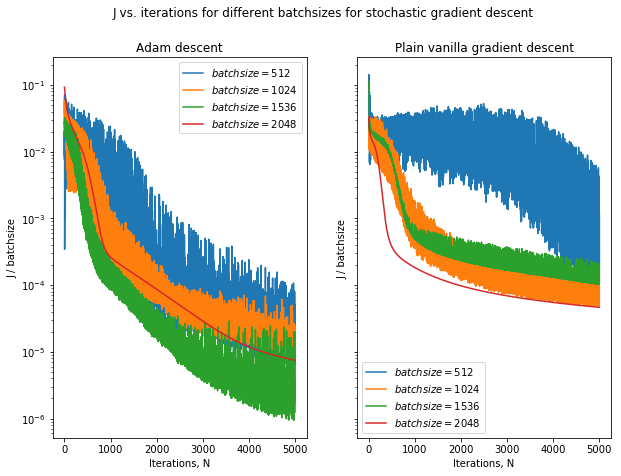

In [15]:
plotParams(batchsize_list, "batch", K = K , d = d_0)

The graphs illustrate that the use of stochastic gradient descent causes the objective function to oscillate around a minimum instead of converging smoothly and that decrasing the batchsize increases the range of the oscillations.  

However, decreasing the batchsize also decreases the runtime which is especially relevant when training for large amounts of input data. From the graphs it can be seen that using half the input data causes relatively regular oscillations and does converges, so that this will be a reasonable choice when using stochastic gradient descent.

When using smaller amounts of input data it is not necessary to use stochastic gradient descent to decrease the runtime, so we have chosen not to do so for the known functions in this project. We will also not use stochastic gradient descent when investigating further parameter choices as it is easier to evaluate the graphs without oscillations.

#### 3.2 The number of hidden layers, $K$

In [16]:
#define variables for this test   
K_list = np.arange(25,101,25) 

#define lists of filenames where the trained parameters will be stored
filenames_K_A, filenames_K_P = filenameList(K_list, "K")

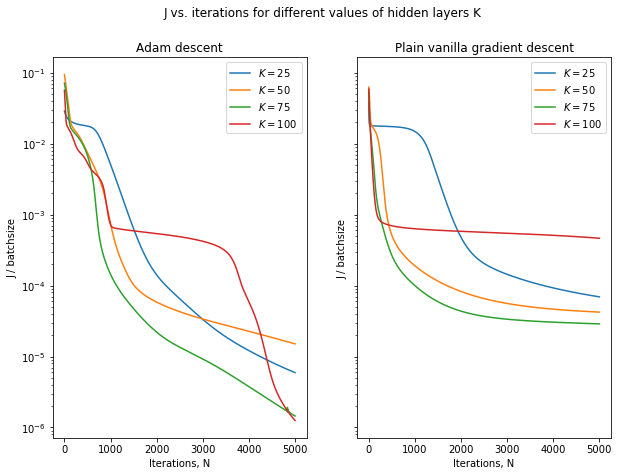

In [17]:
plotParams(K_list, "K", d = d_0, batchsize = batchsize)

The graphs show that the loss function decreases similarly for $K=25$ and $K=75$, although it is somewhat lower for $K=75$. However, a higher number of hidden layers will also increase the runtime considerably so, to balance accuracy and runtime, we will use $K=25$.

#### 3.3 The value of the learning parameter $\tau$

In [18]:
#define variables for this test
tau_list = np.array([0.001,0.004,0.007,0.01])   #learning parameter
K_tau = 25

#define lists of filenames where the trained parameters will be stored
filenames_tau_A, filenames_tau_P = filenameList(tau_list, "tau")

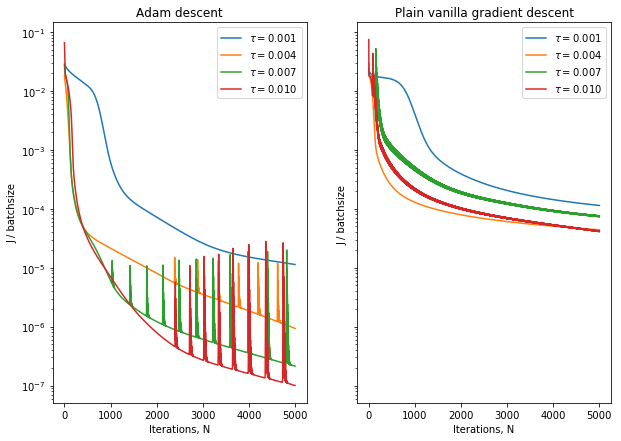

In [19]:
plotParams(tau_list, "tau", K = K_tau, d = d_0, batchsize = batchsize)

Here we can see that the objective function seems to spike intermittently for $\tau=0.004$, $\tau = 0.007$ and $\tau = 0.01$. While it is smooth for $\tau = 0.001$, it also decreases more slowly and converges to a larger value, so that it is not optimal. For $\tau = 0.004$ the spikes start after a higher number of iterations than for the other two and are smaller in magnitude, which makes it the optimal choice for the learning parameter.

#### 3.4 The dimension of the input data in the hidden layers $d$

In [20]:
d_0_list = np.array([3,4,5,6])  
K_d = 25
tau_d = 0.004

#define lists of filenames where the trained parameters will be stored
filenames_d_A, filenames_d_P = filenameList(d_0_list, "d")

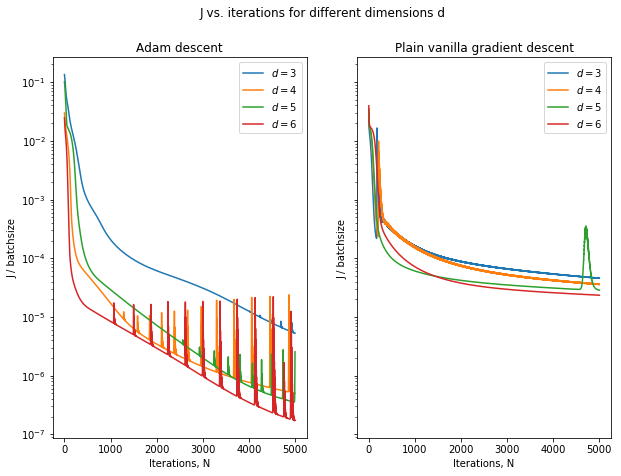

In [21]:
plotParams(d_0_list, "d", K = K_d, batchsize = batchsize)

The original dimension of the input data is $d_0=3$. The graphs illustrate that having a higher dimension in the hidden layers improves the decrease of the loss function even though it also causes some spikes. We choose to use $d=5$ as the dimension of our layers as the spikes in its corresponding loss function are considerably smaller in magnitude than for $d=4$ and $d=6$.

#### 3.5 The stepsize $h$

In [22]:
h_list = np.array([0.05, 0.1, 0.15, 0.2])
K_h = 25
tau_h = 0.004
d_h = 5

#define lists of filenames where the trained parameters will be stored
filenames_h_A, filenames_h_P= filenameList(h_list, "h")

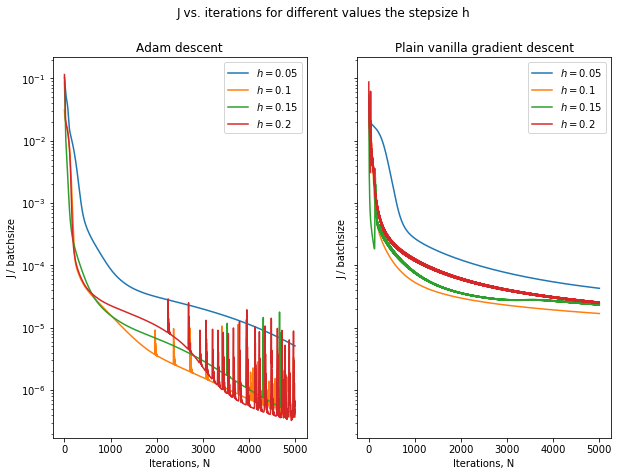

In [23]:
plotParams(h_list, "h", K = K_h, d = d_h, batchsize = batchsize)

From the graphs above we can see that the loss function behaves similarly and is smooth for stepsizes $h=0.1$, $h=0.15$ and $h=0.2$ during the first $N=2000$ iterations. Thereafter however all three develop some occasional spikes. The spiking is a lot more frequent for $h=0.1$ and $h=0.2$, so therefore we choose to use $h=0.15$ as the optimal value.

#### 3.6 Conclusion 

We found that the best parameters, taking both accuracy and runtime into account, were $K = 25$, $\tau = 0.004$, $d=5$ and $h = 0.15$ and will use those in the training. When training for other functions than the unknown Hamiltonian which we used for paramter testing, we will not use $d=5$, but simply $d=2d_0$ as suggested in the Project description.

Throughout all the tests, it is clear that Adam descent is a more efficient optimization method than plain vanilla gradient descent. Therefore we will simply use the Adam descent for all training.

### 4. Training and testing with suggested functions

In [24]:
#defines global variables for all the following tests
h = 0.15                #stepsize
tau = 0.004             #learning parameter
K = 25                  #number of hidden layers

tol = 1e-5              #tolerance for J/batchsize
N = 5000                #number of iterations
tol_dev = (2*tol)**0.5  #tolerated deviation from exact solution

The parameter values corresponding the optimal choices from section 3 as well as stopping criterias for the training algorithm and tolerated deviation between the approximated and exact value is defined. ..

For all the following tests the training algorithm will terminate when the value of the objective function devided by the number of input data point is less than the tolareted value or at least within 5000 iterations. This tolerated value is set to be $10^{-5}$ since by observing the graphs in section 3 there occured spikes ...for lavere verdier overfitting... and ...ha en okei kjøretid... 

The tolerated deviation of the approximated values from the exact values is defined as the sqaureroot of two times the tolerated value of the objective function ..., this derived from the formula of the objective function and our stopping criteria. 


#### 4.1  $F(y) = 1-\cos{y}$

In [25]:
def F(y):
    return 1-np.cos(y)

In [26]:
#define variable used for training with F(y)
d_F = 2        
I_F = 1500 

In [27]:
#read the stored trained parameters
W_F,b_F,omega_F,mu_F,ypsilon_F, J_F, itr_F = readParams(K, d_F, I_F, N, filename='trainingParams_F.txt')
ac_F,bc_F,ac_G,bc_G = readScale('scaleParamsFandG.txt')

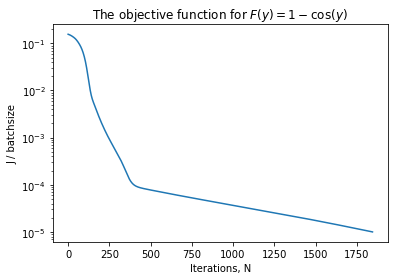

In [85]:
plotObjFnc(J_F, itr_F, I_F, "$F(y) = 1-\cos(y)$")

The training process of the network obtain the tolerated value of J / batchsize within $N=1854$ when the datapoints is trained to coincide (????) with $F(y) = 1-\cos(y)$

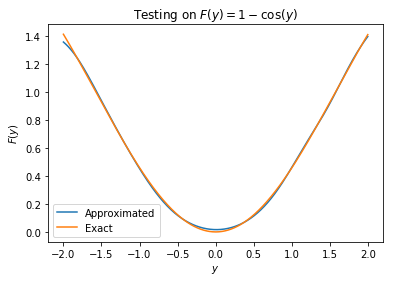

The successrate is 0.6626666666666666
The mean deviation is 0.00363


In [29]:
#testing with F(y)
YTest_F = np.sort(np.random.uniform(-2,2,(1,I_F)))
cTest_F = F(YTest_F)


ypsilonTest_F = testingAlgorithm(YTest_F, W_F, b_F, omega_F, mu_F, K, d_F, I_F, h, sigma, eta, ac_F, bc_F)



#plotting
plt.figure()
plt.plot(YTest_F[0], ypsilonTest_F, label = "Approximated")
plt.plot(YTest_F[0], cTest_F[0], label = "Exact")
plt.xlabel(r"$y$")
plt.ylabel(r"$F(y)$")
plt.title(r"Testing on $F(y) = 1-\cos(y)$")
plt.legend()
plt.show()


cTest_Ftilde, aftest, bftest = scale(cTest_F)
ypsilonTilde_F = scaleYpsilon(ypsilonTest_F, aftest, bftest)


succF, accF = successrate(ypsilonTilde_F, cTest_Ftilde, tol_dev, I_F)
print("The successrate is {}".format(succF) )
print("The mean deviation is %.5f"%accF)

As illustrated in the graph, the network's appoximated values is close to the exact values and deviates mostly around the interval "grenser/ender" in -2 and 2, and around the minima of the function. 

(To improve the network's ability to recognize these function values one could have had used more datapoints in this regions.......??)


#### 4.2 $G(y_1,y_2) = \frac{1}{2} (y_1^2 + y_2^2)$

In [30]:
def G(y1, y2):
    return 1/2 *(y1**2 + y2**2)

In [31]:
#define variable used for training with G(y)
d_G = 4       
I_G = 1500    

In [32]:
W_G,b_G,omega_G,mu_G, ypsilon_G, J_G, itr_G = readParams(K, d_G, I_G, N, filename='trainingParams_G.txt')
ac_F,bc_F,ac_G,bc_G = readScale('scaleParamsFandG.txt')

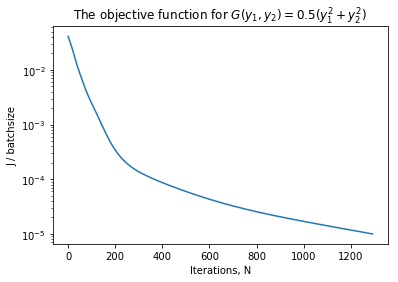

In [33]:
plotObjFnc(J_G, itr_G, I_G, "$G(y_1,y_2) = 0.5 (y_1^2 + y_2^2)$")

The training process of the network obtain the desired value within $N=1292$ when the datapoints is trained to coincide(?) with  $G(y_1,y_2) = \frac{1}{2} (y_1^2 + y_2^2)$ .

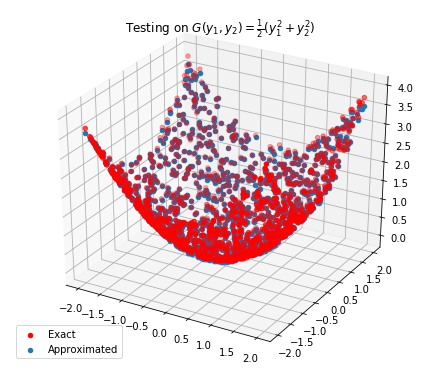

Successrate: 0.75533
Mean deviation: 0.00327


In [34]:
#testing with G(y)
YTest_G = np.random.uniform(-2,2,(2,I_G))
cTest_G = G(YTest_G[0], YTest_G[1])
cTest_G.resize(1,I_G)

ypsilonTest_G = testingAlgorithm(YTest_G, W_G, b_G, omega_G, mu_G, K, d_G, I_G, h, sigma, eta, ac_G, bc_G)


#plotting of G(y)
fig = plt.figure()
fig.set_figheight(6.5)
fig.set_figwidth(7.5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(YTest_G[0], YTest_G[1], cTest_G[0], label = "Exact" , c="red", depthshade = True)
ax.scatter(YTest_G[0], YTest_G[1], ypsilonTest_G, label = "Approximated", depthshade = False)
ax.set_title(r"Testing on $G(y_1, y_2)= \frac{1}{2} (y_1^2 + y_2^2)$")
plt.legend(loc = 'lower left')
plt.show()


#determine successrate and accuracy
cTest_Gtilde, aGtest, bGtest = scale(cTest_G)
ypsilonTilde_G = scaleYpsilon(ypsilonTest_G, aGtest, bGtest)

succG, accG = successrate(ypsilonTilde_G, cTest_Gtilde, tol_dev, I_G)
print("Successrate: %.5f"%succG)
print("Mean deviation: %.5f"%accG)

This graph illustrate that the appoximated values tends(?) to the exact values, but from the graph it is hard to tell exacally how much it deviates or in which regions/areas its deviates most. Nevertheless, the proportion of values qualified as sufficiently close to the exact value is determined to about 75% and the mean deviation is .... .

#### 4.3 Known Hamiltonian 

#### 4.3.1 Nonlinear pendel

In [35]:
m = 1E-2
l = 0.5
g = 9.81

def T_pend(p):
    return 0.5*p**2

def V_pend(q):
    return m*g*l*(1-np.cos(q))

In [36]:
I_p = 1500
d_p = 2

In [37]:
W_Tpend,b_Tpend,omega_Tpend,mu_Tpend, ypsilon_Tpend, J_Tpend, itr_Tpend = readParams(K, d_p, I_p, N, filename='trainingParams_Tpend.txt')
W_Vpend,b_Vpend,omega_Vpend,mu_Vpend, ypsilon_Vpend, J_Vpend, itr_Vpend = readParams(K, d_p, I_p, N, filename='trainingParams_Vpend.txt')
aVp,bVp,aTp,bTp = readScale('scaleParamsPend.txt')

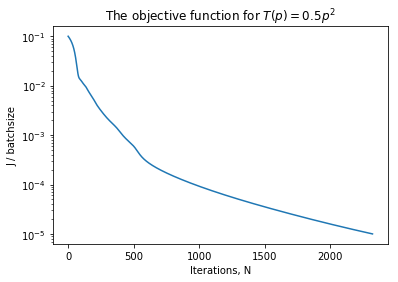

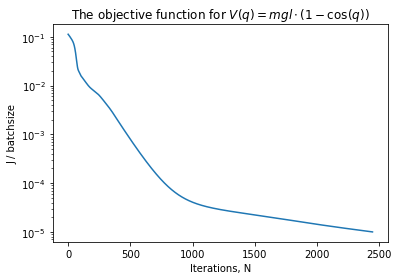

In [38]:
plotObjFnc(J_Tpend, itr_Tpend, I_p, "$T(p) = 0.5p^2$")
plotObjFnc(J_Vpend, itr_Vpend, I_p, "$V(q) = mgl\cdot(1-\cos(q))$")

The network obtains the desired value $10^{-5}$ after about 2500 iterations for both $T(p)$ and $V(q)$ for a nonlinear pendelum.

..when the network is trained to recognize/coincide with these two functions.

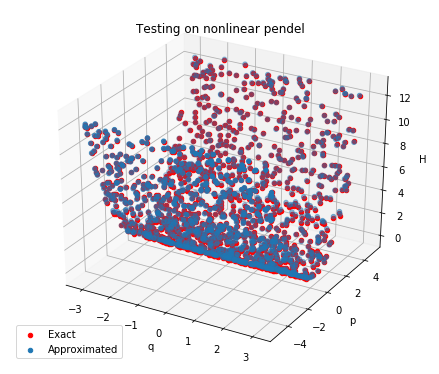

Successrate for V(q): 0.84667
Mean deviation for V(q): 0.00223
Successrate for T(p): 0.63267
Mean deviation for T(p): 0.00349

Successrate for H(p,q): 0.59800
Mean deviation for H(p,q): 0.00406


In [39]:
#testing with V_pend(q) and T_pend(p)
q_pTest = np.random.uniform(-np.pi,np.pi,(1,I_p))
V_pTest = V_pend(q_pTest)
p_pTest = np.random.uniform(-5,5,(1,I_p))
T_pTest = T_pend(p_pTest)


ypsilonTest_Vpend = testingAlgorithm(q_pTest, W_Vpend, b_Vpend, omega_Vpend, mu_Vpend, K, d_p, I_p, h, sigma, eta, aVp, bVp)
ypsilonTest_Tpend = testingAlgorithm(p_pTest, W_Tpend, b_Tpend, omega_Tpend, mu_Tpend, K, d_p, I_p, h, sigma, eta, aTp, bTp)


#plotting 
fig = plt.figure()
fig.set_figheight(6.5)
fig.set_figwidth(7.5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(q_pTest[0], p_pTest[0], V_pTest[0]+T_pTest[0], label = "Exact" , c="red", depthshade = False)
ax.scatter(q_pTest[0], p_pTest[0], ypsilonTest_Vpend[:,0]+ypsilonTest_Tpend[:,0], label = "Approximated", depthshade = True)
ax.set_title(r"Testing on nonlinear pendel")
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_zlabel("H")
plt.legend(loc = 'lower left')
plt.show()


#determine the successrates and accuracies 
V_pTilde, aVpend_test, bVpend_test = scale(V_pTest)
ypsilonTilde_Vpend = scaleYpsilon(ypsilonTest_Vpend, aVpend_test, bVpend_test)

T_pTilde, aTpend_test, bTpend_test = scale(T_pTest)
ypsilonTilde_Tpend = scaleYpsilon(ypsilonTest_Tpend, aTpend_test, bTpend_test)

succVpend, accVpend = successrate(ypsilonTilde_Vpend, V_pTilde, tol_dev, I_p)
succTpend, accTpend = successrate(ypsilonTilde_Tpend, T_pTilde, tol_dev, I_p)

succHpend, accHpend = successrate(ypsilonTilde_Vpend+ypsilonTilde_Tpend, V_pTilde+T_pTilde, tol_dev, I_p)
print("Successrate for V(q): %.5f"%succVpend)
print("Mean deviation for V(q): %.5f"%accVpend)

print("Successrate for T(p): %.5f"%succTpend)
print("Mean deviation for T(p): %.5f\n"%accTpend)

print("Successrate for H(p,q): %.5f"%succHpend)
print("Mean deviation for H(p,q): %.5f"%accHpend)

By calucaing the succeccrates and accuracy for $V(q)$ and $T(p)$, one see that the porportion of succeccrate is better for $V(q)$ than $T(p)$ but both of the rates indicated that the network ...fungerte relativt godt... 

The graph plots the exact Hamiltonian vs. the approximated Hamiltonian function in terms of the nonlinear pendelum. The succeccrates was calculated to be approximatly 60% with an mean deviation of about 0.004. 

#### 4.3.2 Kepler

In [40]:
def T_Kepler(p):
    T_p = np.zeros((1,p.shape[1]))
    for i in range(p.shape[1]):
        T_p[:,i] = 1/2*np.transpose(p[:,i])@p[:,i]
    return T_p

def V_Kepler(q1,q2):
    return -1/np.sqrt(q1**2+q2**2)

In [41]:
I_K = 1500
d_K = 4

In [42]:
W_TK,b_TK,omega_TK,mu_TK, ypsilon_TK, J_TK, itr_TK = readParams(K, d_K, I_K, N, filename='trainingParams_TKepler.txt')
W_VK,b_VK,omega_VK,mu_VK, ypsilon_VK, J_VK, itr_VK = readParams(K, d_K, I_K, N, filename='trainingParams_VKepler.txt')
aVK,bVK,aTK,bTK = readScale('scaleParamsKepler.txt')

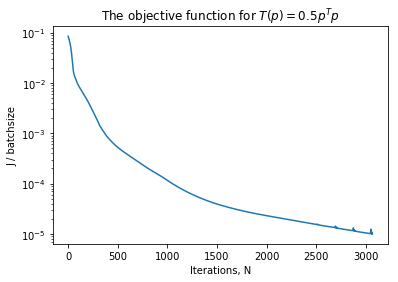

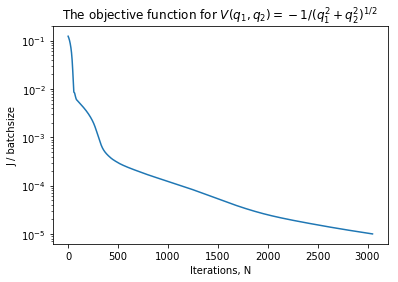

In [43]:
#plotting of objective function
plotObjFnc(J_TK, itr_TK, I_K, '$T(p) = 0.5 p^T p$')
plotObjFnc(J_VK, itr_VK, I_K, '$V(q_1, q_2)= - 1 / (q_1^2 + q_2^2)^{1/2}$')

The network obtains the desired value $10^{-5}$ after about 3000 iterations for both $T(p)$ and $V(q)$ for the Kepler two-body problem.

In [44]:
#testing with V_Kepler(q) and T_Kepler(p)
q_KTest = np.random.uniform(-10,10,(2,I_K))
V_KTest = V_Kepler(q_KTest[0], q_KTest[1])
V_KTest.resize(1,I_K)
p_KTest = np.random.uniform(-10,10,(2,I_K))
T_KTest = T_Kepler(p_KTest)
T_KTest.resize(1,I_K)

ypsilonTest_VKepler = testingAlgorithm(q_KTest, W_VK, b_VK, omega_VK, mu_VK, K, d_K, I_K, h, sigma, eta, aVK, bVK)
ypsilonTest_TKepler = testingAlgorithm(p_KTest, W_TK, b_TK, omega_TK, mu_TK, K, d_K, I_K, h, sigma, eta, aTK, bTK)

In [45]:
#determine the succeccrates and accuracies for Kepler two-body. 
V_KTilde, aVKepler_test, bVKepler_test = scale(V_KTest)
ypsilonTilde_VKepler = scaleYpsilon(ypsilonTest_VKepler, aVKepler_test, bVKepler_test)

succVKepler, accVKepler = successrate(ypsilonTilde_VKepler, V_KTilde, tol_dev, I_K)

T_KTilde, aTKepler_test, bTKepler_test = scale(T_KTest)
ypsilonTilde_TKepler = scaleYpsilon(ypsilonTest_TKepler, aTKepler_test, bTKepler_test)

succTKepler, accTKepler = successrate(ypsilonTilde_TKepler, T_KTilde, tol_dev, I_K)

succHKepler, accHKepler = successrate(ypsilonTilde_TKepler + ypsilonTilde_VKepler, T_KTilde + V_KTilde, tol_dev, I_K)

print("Testing on Kepler two-body problem\n")
print("Successrate for V(q): %.5f"%succVKepler)
print("Mean deviation for V(q): %.5f"%accVKepler)

print("Successrate for T(p): %.5f"%succTKepler)
print("Mean deviation for T(p): %.5f\n"%accTKepler)

print("Successrate for H(p,q): %.5f"%succHKepler)
print("Mean deviation for H(p,q): %.5f"%accHKepler)

Testing on Kepler two-body problem

Successrate for V(q): 0.54067
Mean deviation for V(q): 0.00596
Successrate for T(p): 0.34400
Mean deviation for T(p): 0.00790

Successrate for H(p,q): 0.33200
Mean deviation for H(p,q): 0.00913


Also in this case, the network seems to approximate $V(q)$ more accurate than T(p), with mean deviations of respectively $0.0036$ and $0.0081$. 

Since Kepler two-body problem is a two?? dimensional problem including ..... it is impossible/difficult to illustrate the result through a graph that ... viser ikke hele sannheten ... 

Overall, the successrate for this Hamiltonian was about 0.35 / 35% and the mean deviation was determined as $0.0082$. 

#### 4.4 Unknown Hamiltonian

In [46]:
trainingBatch = concatenate(0,25)

In [47]:
I_T = trainingBatch["P"].shape[1]
d_T = 5
batchsize = int(I_T/2)

In [48]:
W_TT,b_TT,omega_TT,mu_TT, ypsilon_TT, J_TT, itr_TT = readParams(K, d_T, batchsize, N, filename='trainingParams_TUnknown.txt')

W_VT,b_VT,omega_VT,mu_VT, ypsilon_VT, J_VT, itr_VT = readParams(K, d_T, batchsize, N, filename='trainingParams_VUnknown.txt')

aVT, bVT, aTT, bTT = readScale("scaleParamsUnknown.txt")

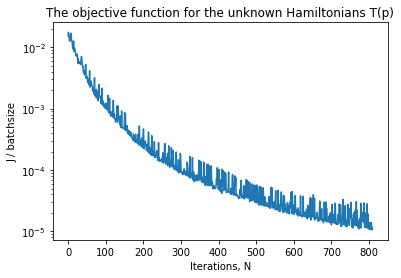

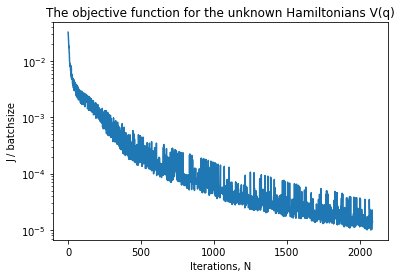

In [49]:
#plotting of objective function
plotObjFnc(J_TT, itr_TT, batchsize, "the unknown Hamiltonians T(p)")
plotObjFnc(J_VT, itr_VT, batchsize, "the unknown Hamiltonians V(q)")

In [50]:
batch_unknown = generate_data(27)

p_unknown = batch_unknown["P"][:1,:]
q_unknown = batch_unknown["Q"][:1,:]

I_unknown = p_unknown.shape[1]

p_unknown0 = p_unknown
q_unknown0 = q_unknown

ones = np.ones((2,I_unknown))
p_unknown1 = np.vstack((p_unknown,ones))
q_unknown1 = np.vstack((q_unknown,ones))


ypsilonT_unknown0 = testingAlgorithm(p_unknown0,W_TT,b_TT,omega_TT,mu_TT, K, d_T, I_unknown, h, sigma, eta, aTT, bTT)
ypsilonT_unknown1 = testingAlgorithm(p_unknown1,W_TT,b_TT,omega_TT,mu_TT, K, d_T, I_unknown, h, sigma, eta, aTT, bTT)

ypsilonV_unknown0 = testingAlgorithm(q_unknown0,W_VT,b_VT,omega_VT,mu_VT, K, d_T, I_unknown, h, sigma, eta, aVT, bVT)
ypsilonV_unknown1 = testingAlgorithm(q_unknown1,W_VT,b_VT,omega_VT,mu_VT, K, d_T, I_unknown, h, sigma, eta, aVT, bVT)

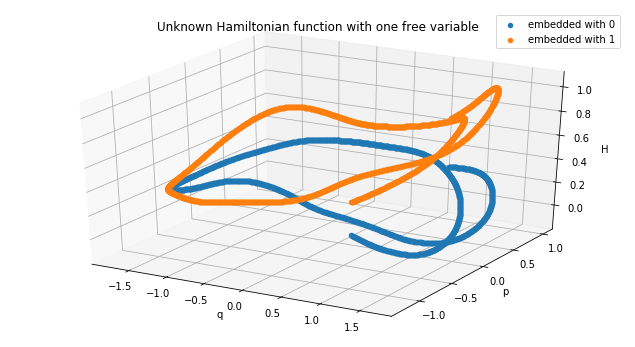

In [88]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(11)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(q_unknown0[0], p_unknown0[0], ypsilonV_unknown0+ypsilonT_unknown0, label = "embedded with 0", depthshade = False)
ax.scatter(q_unknown1[0], p_unknown1[0], ypsilonV_unknown1+ypsilonT_unknown1, label = "embedded with 1", depthshade = False)
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_zlabel(r"H")
ax.set_title("Unknown Hamiltonian function with one free variable")

ax.legend(loc = 'best')
plt.show()


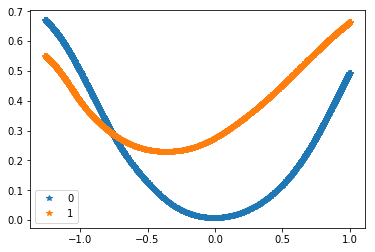

In [52]:
plt.figure()
plt.plot(p_unknown0[0], ypsilonT_unknown0,"*", label = "0")
plt.plot(p_unknown1[0], ypsilonT_unknown1,"*", label = "1")
plt.legend()
plt.show()

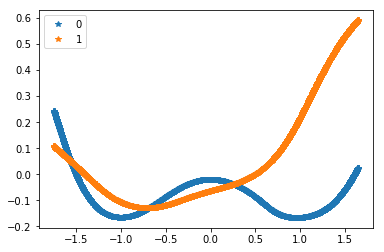

In [53]:
plt.figure()
plt.plot(q_unknown0[0], ypsilonV_unknown0,"*", label = "0")
plt.plot(q_unknown1[0], ypsilonV_unknown1,"*", label = "1")
plt.legend()
plt.show()

In [54]:
batch_unknown = generate_data(27)

p_testUnknown = batch_unknown["P"]
q_testUnknown = batch_unknown["Q"]
V_testUnknown = batch_unknown["V"]
T_testUnknown = batch_unknown["T"]

I_unknown = p_testUnknown.shape[1]

ypsilonTest_Tunknown = testingAlgorithm(p_testUnknown,W_TT,b_TT,omega_TT,mu_TT, K, d_T, I_unknown, h, sigma, eta, aTT, bTT)
ypsilonTest_Vunknown = testingAlgorithm(q_testUnknown,W_VT,b_VT,omega_VT,mu_VT, K, d_T, I_unknown, h, sigma, eta, aVT, bVT)

In [55]:
V_tildeUnknown, aVUnknown_test, bVUnknown_test = scale(V_testUnknown)
ypsilonTilde_Vunknown = scaleYpsilon(ypsilonTest_Vunknown, aVUnknown_test, bVUnknown_test)

succVUnknown, accVUnknown = successrate(ypsilonTilde_Vunknown, V_tildeUnknown, tol_dev, I_unknown)


T_tildeUnknown, aTUnknown_test, bTUnknown_test = scale(T_testUnknown)
ypsilonTilde_Tunknown = scaleYpsilon(ypsilonTest_Tunknown, aTUnknown_test, bTUnknown_test)

succTUnknown, accTUnknown = successrate(ypsilonTilde_Tunknown, T_tildeUnknown, tol_dev, I_unknown)

succHUnknown, accHUnknown = successrate(ypsilonTilde_Tunknown + ypsilonTilde_Vunknown, T_tildeUnknown + V_tildeUnknown, tol_dev, I_unknown)

print("Testing on the unknown Hamiltonian")
print("Successrate for V(q): %.5f"%succVUnknown)
print("Mean deviation for V(q): %.5f"%accVUnknown)

print("Successrate for T(p): %.5f"%succTUnknown)
print("Mean deviation for T(p): %.5f\n"%accTUnknown)

print("Successrate for H(p,q): %.5f"%succHUnknown)
print("Mean deviation for H(p,q): %.5f"%accHUnknown)

Testing on the unknown Hamiltonian
Successrate for V(q): 0.45898
Mean deviation for V(q): 0.02359
Successrate for T(p): 0.15479
Mean deviation for T(p): 0.07580

Successrate for H(p,q): 0.03760
Mean deviation for H(p,q): 0.09581


### 5. Computing the gradient 

We wish to compute the gradient of the Hamiltonian functions from the trained neurale networks. From the hint on Blackboard we have derived 
$$\nabla F(y) = \left(D\Psi_{K-1}(y)\right)^T\nabla G(Z^{(K)}) $$
where 
$$\nabla G(Z^{(K)}) = \eta'(\omega^TZ^{(K)}+\mu)\omega,$$
$$(D\Psi_{K-1}(y))^T = (D\Psi_{K-2}(y))^T\left(\Phi_{K-1}(Z^{(K-1)}) \right)^T$$
and
$$D\Phi(Z^{(K-1)})^TA = A + W^T(h\sigma'(WZ^{(K-1)}+b) \odot A).$$
This is implemented below with the help of backward propagation.


In [56]:
def inverseScaleGrad(x_tilde, a, b, alpha = 0.2, beta = 0.8):
    return 1/(beta-alpha)*(x_tilde*b - x_tilde*a)

def gradF(y, omega, mu, W, b, K, d, h, sigma, eta_div, sigma_div):
    d0 = y.shape[0]
    I = y.shape[1]
    
    #reshapes input to match dimension of layers
    if d0 > d:
        print("d must be larger than d0")
    
    if d0 < d:
        zero = np.zeros((d-d0,I))
        y = np.vstack((y,zero))
    
    Z = getZ(y, W, b, K, d, I, h, sigma)
    A = eta_div(np.transpose(omega)@Z[K] + mu)*omega 
    for k in range(K,0,-1): 
        B = h*sigma_div(W[k-1]@Z[k-1]+b[k-1])
        u = B*A
        A = A + np.transpose(W[k-1])@u
    
    return A[0:d0,:]

### 6. Numerical methods 

In [57]:
def symplecticEuler(gradF, t, q0, p0, omega_V, mu_V, W_V, b_V, a_Vgrad, b_Vgrad, omega_T, mu_T, W_T, b_T, a_Tgrad, b_Tgrad, K, d, h, sigma, eta_div, sigma_div): 

    q = np.zeros((q0.shape[0], q0.shape[1],len(t)))
    p = np.zeros((p0.shape[0], p0.shape[1],len(t)))
    
    q[:,:,0] = q0
    p[:,:,0] = p0
    
    for n in range(len(t)-1):
        delta_t = t[n+1]-t[n] 
        
        dTdp = gradF(p[:,:,n], omega_T, mu_T, W_T, b_T, K, d, h, sigma, eta_div, sigma_div)
        q[:,:,n+1] = q[:,:,n] + delta_t*inverseScaleGrad(dTdp,a_Tgrad,b_Tgrad)
        
        dVdq = gradF(q[:,:,n+1], omega_V, mu_V, W_V, b_V, K, d, h, sigma, eta_div, sigma_div)
        p[:,:,n+1] = p[:,:,n] - delta_t*inverseScaleGrad(dVdq,a_Vgrad,b_Vgrad)
    
    return q,p

In [58]:
def Stromer_Verlet(gradF, t, q0, p0, omega_V, mu_V, W_V, b_V, a_Vgrad, b_Vgrad, omega_T, mu_T, W_T, b_T, a_Tgrad, b_Tgrad, K, d, h, sigma, eta_div, sigma_div): 
    
    q = np.zeros((q0.shape[0], q0.shape[1], len(t)))
    p = np.zeros((p0.shape[0], p0.shape[1], len(t)))
    
    q[:,:,0] = q0
    p[:,:,0] = p0
    
    for n in range(len(t)-1):
        delta_t = t[n+1]-t[n]
        
        dVdq_n = gradF(q[:,:,n], omega_V, mu_V, W_V, b_V, K, d, h, sigma, eta_div, sigma_div)
        u = p[:,:,n] - delta_t/2*inverseScaleGrad(dVdq_n, a_Vgrad, b_Vgrad) #u = p_{n+1/2}
        dTdp = gradF(u, omega_T, mu_T, W_T, b_T, K, d, h, sigma, eta_div, sigma_div)
        q[:,:,n+1] = q[:,:,n] + delta_t*inverseScaleGrad(dTdp, a_Tgrad, b_Tgrad)
        dVdq = gradF(q[:,:,n+1], omega_V, mu_V, W_V, b_V, K, d, h, sigma, eta_div, sigma_div)
        p[:,:,n+1] = u - delta_t/2*inverseScaleGrad(dVdq, a_Vgrad, b_Vgrad)
    
    return q,p

The numerical methods Sympletic Euler and Strømer Verlet with the use of the gradient computed from the neural networks is implementet above. The Sympletic Euler has only order 1, but the Strømer Verlet method have order 2.  

#### 6.1 Nonlinear pendulum

In [59]:
I_p = 1000
d_p = 2

In [60]:
m = 1E-2
l = 0.5
g = 9.81

def T_pend(p):
    return 0.5*p**2

def V_pend(q):
    return m*g*l*(1-np.cos(q))

In [61]:
W_Tpend,b_Tpend,omega_Tpend,mu_Tpend,ypsilon_Tpend, J_Tpend, itr_Tpend = readParams(K, d_p, I_p, N, filename='trainingParams_Tpend.txt')
W_Vpend,b_Vpend,omega_Vpend,mu_Vpend,ypsilon_Vpend, J_Vpend, itr_Vpend = readParams(K, d_p, I_p, N, filename='trainingParams_Vpend.txt')

aVp, bVp, aTp, bTp = readScale("scaleParamsPend.txt")

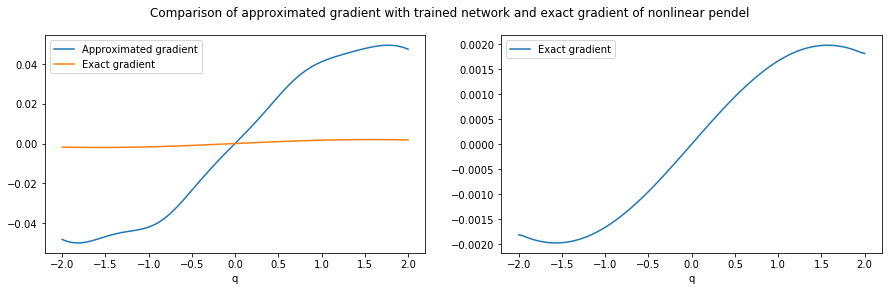

In [62]:
#print(V_p.shape)

q_p = np.linspace(-2,2,100)
V_p = V_pend(q_p)

gradV_numpy = np.gradient(V_p)
#print(gradV_numpy)

q_p.resize((1,100))

gradV = gradF(q_p, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, K, d_p, h, sigma, eta_div, sigma_div)
gradV = inverseScaleGrad(gradV, aVp, bVp)


fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(15)

ax = axs[0]
ax.plot(q_p[0], gradV[0], label = "Approximated gradient")
ax.plot(q_p[0], gradV_numpy, label = "Exact gradient")
ax.set_xlabel("q")
ax.legend()


ax = axs[1]
ax.plot(q_p[0], gradV_numpy, label = "Exact gradient")
ax.set_xlabel("q")
ax.legend()


fig.suptitle("Comparison of approximated gradient with trained network and exact gradient of nonlinear pendel")

plt.show()

From the graph on the left we can see that the values of the approximated gradient is wrong, but the graph on the right we can see that the shape of the approximated gradient is correct. 

In [63]:
q0 = np.zeros((1,1))
p0 = np.zeros((1,1))
t = np.linspace(0,10,100)

q_sympEuler_pend, p_sympEuler_pend = symplecticEuler(gradF, t, q0, p0, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, aVp, bVp, omega_Tpend, mu_Tpend, W_Tpend, b_Tpend, aTp, bTp, K, d_p, h, sigma, eta_div, sigma_div)

q_StromerVerlet_pend, p_StromerVerlet_pend = Stromer_Verlet(gradF, t, q0, p0, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, aVp, bVp, omega_Tpend, mu_Tpend, W_Tpend, b_Tpend, aTp, bTp, K, d_p, h, sigma, eta_div, sigma_div)

In [64]:
p_sympEuler_pend.resize((1,100))
q_sympEuler_pend.resize((1,100))
T_net_sympEuler_pend = testingAlgorithm(p_sympEuler_pend, W_Tpend,b_Tpend,omega_Tpend,mu_Tpend, K, d_p, 100, h, sigma, eta, aTp, bTp)
V_net_sympEuler_pend = testingAlgorithm(q_sympEuler_pend, W_Vpend,b_Vpend,omega_Vpend,mu_Vpend, K, d_p, 100, h, sigma, eta, aVp, bVp)

p_StromerVerlet_pend.resize((1,100))
q_StromerVerlet_pend.resize((1,100))
T_net_StromerVerlet_pend = testingAlgorithm(p_StromerVerlet_pend, W_Tpend,b_Tpend,omega_Tpend,mu_Tpend, K, d_p, 100, h, sigma, eta, aTp, bTp)
V_net_StromerVerlet_pend = testingAlgorithm(q_StromerVerlet_pend, W_Vpend,b_Vpend,omega_Vpend,mu_Vpend, K, d_p, 100, h, sigma, eta, aVp, bVp)

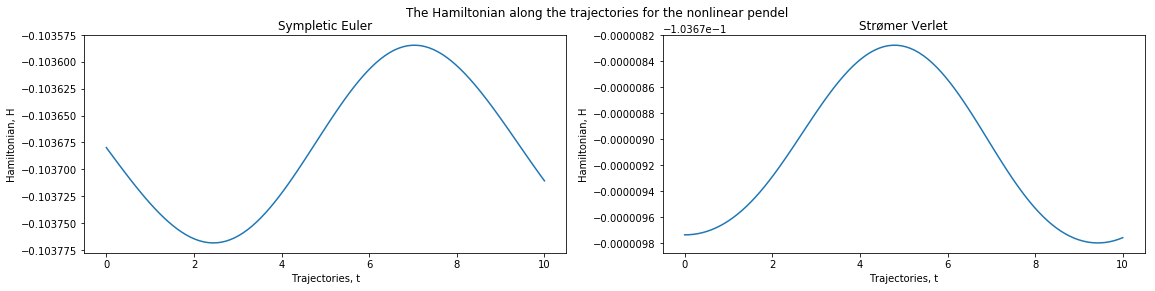

In [65]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(19)

ax = axs[0]
ax.plot(t,T_net_sympEuler_pend+V_net_sympEuler_pend)
ax.set_title("Sympletic Euler")
ax.set_xlabel("Trajectories, t")
ax.set_ylabel("Hamiltonian, H")

ax = axs[1]
ax.plot(t,T_net_StromerVerlet_pend+V_net_StromerVerlet_pend)
ax.set_title("Strømer Verlet")
ax.set_xlabel("Trajectories, t")
ax.set_ylabel("Hamiltonian, H")

fig.suptitle("The Hamiltonian along the trajectories for the nonlinear pendel")

plt.show()

#### 6.2 Kepler two body 

In [66]:
I_K = 1500
d_K = 4

In [67]:
def T_Kepler(p):
    T_p = np.zeros((1,p.shape[1]))
    for i in range(p.shape[1]):
        T_p[:,i] = 1/2*np.transpose(p[:,i])@p[:,i]
    return T_p

def V_Kepler(q1,q2):
    return -1/np.sqrt(q1**2+q2**2)

In [68]:
W_TK,b_TK,omega_TK,mu_TK, ypsilon_TK, J_TK, itr_TK = readParams(K, d_K, I_K, N, filename='trainingParams_TKepler.txt')
W_VK,b_VK,omega_VK,mu_VK, ypsilon_VK, J_VK, itr_VK = readParams(K, d_K, I_K, N, filename='trainingParams_VKepler.txt')

aVK, bVK, aTK, bTK = readScale("scaleParamsKepler.txt")

In [69]:
q0 = np.array([0.2,0.2])
q0.resize((2,1))
p0 = np.zeros((2,1))
t = np.linspace(0,100,100)

q_sympEulerK, p_sympEulerK = symplecticEuler(gradF, t, q0, p0, omega_VK, mu_VK, W_VK, b_VK, aVK, bVK, omega_TK, mu_TK, W_TK, b_TK, aTK, bTK, K, d_K, h, sigma, eta_div, sigma_div)

q_StromerVerletK, p_StromerVerletK = Stromer_Verlet(gradF, t, q0, p0, omega_VK, mu_VK, W_VK, b_VK, aVK, bVK, omega_TK, mu_TK, W_TK, b_TK, aTK, bTK, K, d_K, h, sigma, eta_div, sigma_div)

In [70]:
p_sympEulerK.resize((2,100))
q_sympEulerK.resize((2,100))
T_net_sympEulerK = testingAlgorithm(p_sympEulerK, W_TK,b_TK,omega_TK,mu_TK, K, d_K, 100, h, sigma, eta, aTK, bTK)
V_net_sympEulerK = testingAlgorithm(q_sympEulerK, W_VK,b_VK,omega_VK,mu_VK, K, d_K, 100, h, sigma, eta, aVK, bVK)

p_StromerVerletK.resize((2,100))
q_StromerVerletK.resize((2,100))
T_net_StromerVerletK = testingAlgorithm(p_StromerVerletK, W_TK,b_TK,omega_TK,mu_TK, K, d_K, 100, h, sigma, eta, aTK, bTK)
V_net_StromerVerletK = testingAlgorithm(q_StromerVerletK, W_VK,b_VK,omega_VK,mu_VK, K, d_K, 100, h, sigma, eta, aVK, bVK)

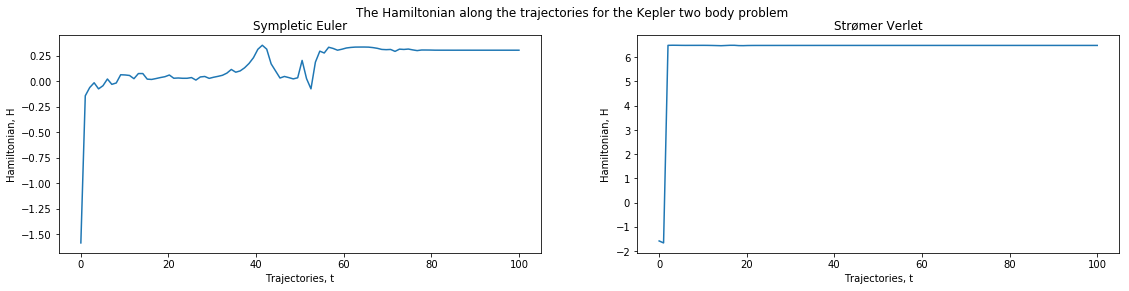

In [71]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(19)

ax = axs[0]
ax.plot(t,T_net_sympEulerK+V_net_sympEulerK)
ax.set_title("Sympletic Euler")
ax.set_xlabel("Trajectories, t")
ax.set_ylabel("Hamiltonian, H")

ax = axs[1]
ax.plot(t,T_net_StromerVerletK+V_net_StromerVerletK)
ax.set_title("Strømer Verlet")
ax.set_xlabel("Trajectories, t")
ax.set_ylabel("Hamiltonian, H")

fig.suptitle("The Hamiltonian along the trajectories for the Kepler two body problem")

plt.show()

#### 6.3 Unknown

In [72]:
batchGrad = generate_data(40)
q0 = batchGrad["Q"][:,0]
p0 = batchGrad["P"][:,0]

d0 = q0.shape[0]

q0.resize((d0,1))
p0.resize((d0,1))

tU = batchGrad["t"]

In [73]:
W_TT,b_TT,omega_TT,mu_TT, ypsilon_TT, J_TT, itr_TT = readParams(K, d_T, batchsize, N, filename='trainingParams_TUnknown.txt')
W_VT,b_VT,omega_VT,mu_VT, ypsilon_VT, J_VT, itr_VT = readParams(K, d_T, batchsize, N, filename='trainingParams_VUnknown.txt')

aVT, bVT, aTT, bTT = readScale("scaleParamsUnknown.txt")

In [74]:
q_sympEulerU, p_sympEulerU = symplecticEuler(gradF, tU, q0, p0, omega_VT, mu_VT, W_VT, b_VT, aVT, bVT, omega_TT, mu_TT, W_TT, b_TT, aTT, bTT, K, d_T, h, sigma, eta_div, sigma_div)

q_StromerVerletU, p_StromerVerletU = Stromer_Verlet(gradF, tU, q0, p0, omega_VT, mu_VT, W_VT, b_VT, aVT, bVT, omega_TT, mu_TT, W_TT, b_TT, aTT, bTT, K, d_T,h, sigma, eta_div, sigma_div)

In [75]:
p_sympEulerU.resize((d0,len(tU)))
q_sympEulerU.resize((d0,len(tU)))
T_net_sympEulerU = testingAlgorithm(p_sympEulerU, W_TT,b_TT,omega_TT,mu_TT, K, d_T, len(tU), h, sigma, eta, aTT, bTT)
V_net_sympEulerU = testingAlgorithm(q_sympEulerU, W_VT,b_VT,omega_VT,mu_VT, K, d_T, len(tU), h, sigma, eta, aVT, bVT)

p_StromerVerletU.resize((d0,len(tU)))
q_StromerVerletU.resize((d0,len(tU)))
T_net_StromerVerletU = testingAlgorithm(p_StromerVerletU, W_TT,b_TT,omega_TT,mu_TT, K, d_T, len(tU), h, sigma, eta, aTT, bTT)
V_net_StromerVerletU = testingAlgorithm(q_StromerVerletU, W_VT,b_VT,omega_VT,mu_VT, K, d_T, len(tU), h, sigma, eta, aVT, bVT)

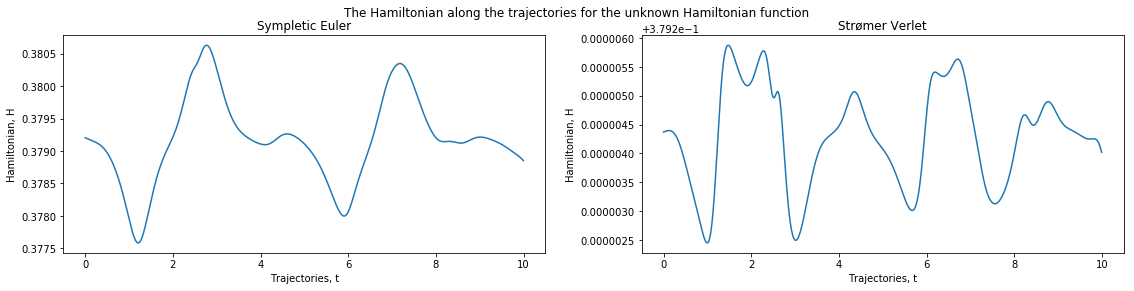

In [76]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(19)

ax = axs[0]
ax.plot(tU,T_net_sympEulerU+V_net_sympEulerU)
ax.set_title("Sympletic Euler")
ax.set_xlabel("Trajectories, t")
ax.set_ylabel("Hamiltonian, H")

ax = axs[1]
ax.plot(tU,T_net_StromerVerletU+V_net_StromerVerletU)
ax.set_title("Strømer Verlet")
ax.set_xlabel("Trajectories, t")
ax.set_ylabel("Hamiltonian, H")

fig.suptitle("The Hamiltonian along the trajectories for the unknown Hamiltonian function")

plt.show()